<a href="https://colab.research.google.com/github/TheRadDani/Label-Smoothing/blob/main/Label_Smoothing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Label Smoothing with CrossEntropyLossWithProbs

Formulation for label Smoothing:


* if smoothing == 0 => One-hot method
* if 0 < smoothing < 1 => it's the smoothing method

In [ ]:
%pip install torchinfo --quiet

In [ ]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import tarfile
from torchinfo import summary
import torchvision.transforms as tt
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
from torchvision.datasets.utils import download_url
from torchvision.datasets import ImageFolder
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

matplotlib.rcParams['figure.facecolor'] = '#ffffff'

Dataloader

In [ ]:
config = {
    "BATCH_SIZE": 32,
    'DEVICE': "cuda" if torch.cuda.is_available() else "cpu",
    "LEARNING_RATE": 1e-3,
    "N_EPOCHS": 20,
    "DROPOUT_RATE": 0.0,
    "REGULARIZATION_RATE": 1e-3,
    "max_lr" : 0.01,
    "grad_clip" : 0.1,
    "weight_decay" : 1e-4,
    "opt_func" : torch.optim.Adam,
    "N_DENSE_1": 512,
    "N_DENSE_2": 128,
}

In [ ]:
dataset_config = {
    'cifar10':
    {
        'dataset_url' : "https://s3.amazonaws.com/fast-ai-imageclas/cifar10.tgz",
        'file':'cifar10.tgz',
        'num_classes' : 10,
        'stats' : ((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    },

    'cifar100' :
     {
        'dataset_url' : "https://s3.amazonaws.com/fast-ai-imageclas/cifar100.tgz",
        'file':'cifar100.tgz',
        'num_classes' : 100,
        'stats' : ((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
     },
     'SVHN' :
     {
        'dataset_url' : "https://s3.amazonaws.com/fast-ai-imageclas/cifar100.tgz",
        'file':'cifar100.tgz',
        'num_classes' : 100,
        'stats' : ((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
     },
    'coco2017':
    {

    },
    'imagenet':
    {
        'dataset_url' : "http://www.image-net.org/challenges/LSVRC/2012/nnoupb/ILSVRC2012_img_train.tar.gz",
        'file':"ILSVRC2012_img_train.tar.gz",
        'num_classes' : 1000,
        'stats' : ((0.485,0.456,0.406), (0.229, 0.224, 0.225))
    },
    'human_emotions':
    {
        'size' : (224, 224),
        'num_classes' : 3,
        'stats' : ((0.485,0.456,0.406), (0.229, 0.224, 0.225)),
        'class_names' : ["angry", "happy", "sad"],
    }
}

In [ ]:
class Dataset():
    def __init__(self,dataset):
        self.dataset = dataset
        self.stats = dataset_config[self.dataset]['stats']
        self.file = dataset_config[self.dataset]["file"].split('.')[0]
        self.data_dir = f'./{self.file}/{self.file}'

    def get_dataset(self):
      download_url(dataset_config[self.dataset]['dataset_url'], './')

      # Extract from archive

      with tarfile.open(f'./{dataset_config[self.dataset]["file"]}', 'r:gz') as tar:
          tar.extractall(path=f'./{self.file}')

    def data_augmentation(self):
        # Data transforms (normalization & data augmentation)

        train_tfms = tt.Compose([
                                tt.RandomCrop(32, padding=4, padding_mode='reflect'),
                                 tt.RandomHorizontalFlip(),
                                 #tt.RandomRotate,
                                 tt.RandomResizedCrop(256, scale=(0.5,0.9), ratio=(1, 1)),
                                 tt.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
                                 tt.Resize((224, 224),interpolation=tt.InterpolationMode.BILINEAR),  # Resize the image to 256x256
                                 tt.ToTensor(),
                                 tt.Normalize(*self.stats,inplace=True)])
        valid_tfms = tt.Compose([
                                tt.Resize((224, 224),interpolation=tt.InterpolationMode.BILINEAR),  # Resize the image to 256x256
                                tt.ToTensor(),
                                tt.Normalize(*self.stats)])

        return (train_tfms,valid_tfms)

    def dataset_creation(self):
      from torchvision.models import MobileNet_V3_Small_Weights

      weights = MobileNet_V3_Small_Weights.DEFAULT
      preprocess = weights.transforms()
      train_tfms, valid_tfms = self.data_augmentation()

      '''train_ds = ImageFolder(self.data_dir+'/train', transform=train_tfms)
      valid_ds = ImageFolder(self.data_dir+'/test', transform =valid_tfms)'''
      train_ds = ImageFolder(self.data_dir+'/train', transform = preprocess)
      valid_ds = ImageFolder(self.data_dir+'/test', transform = valid_tfms)
      return (train_ds,valid_ds)

    def get_classes(self):

      classes = os.listdir(self.data_dir + "/train")
      return classes

    def data_loaders(self):

      train_ds,valid_ds = self.dataset_creation()
      train_dl = DataLoader(train_ds, config['BATCH_SIZE'], shuffle=True, num_workers=3, pin_memory=True)
      val_dl = DataLoader(valid_ds, config['BATCH_SIZE']*2, num_workers=3, pin_memory=True)
      return (train_dl,val_dl)

    def denormalize(self,images, means, stds):
      means = torch.tensor(means).reshape(1, 3, 1, 1)
      stds = torch.tensor(stds).reshape(1, 3, 1, 1)
      return images * stds + means

    def show_batch(self,dl):
      for images, labels in dl:
          fig, ax = plt.subplots(figsize=(12, 12))
          ax.set_xticks([]); ax.set_yticks([])
          denorm_images = self.denormalize(images, *self.stats)
          ax.imshow(make_grid(denorm_images[:64], nrow=8).permute(1, 2, 0).clamp(0,1))
          break

Using downloaded and verified file: ./cifar10.tgz


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


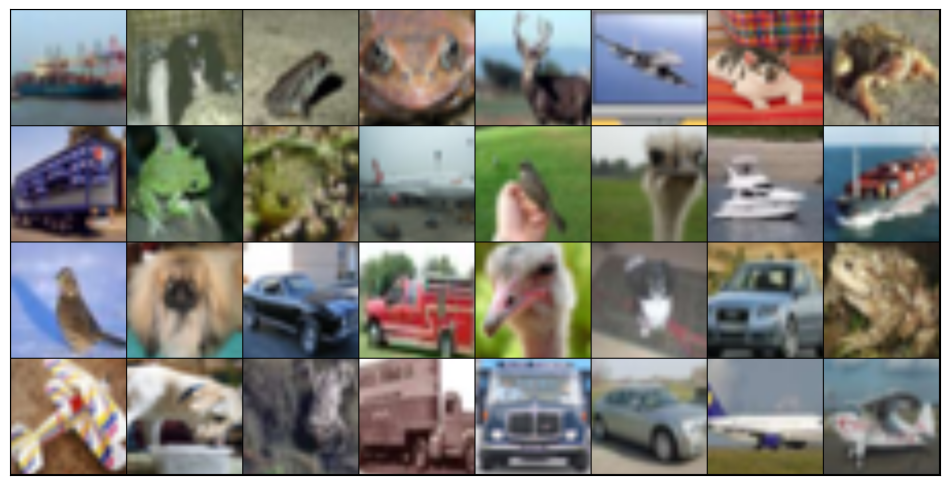

In [ ]:
dataset = Dataset('cifar10')
dataset.get_dataset()
train_ds,val_ds = dataset.dataset_creation()
train_dl,val_dl = dataset.data_loaders()
dataset.show_batch(train_dl)

In [ ]:
def to_device(data,device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x,device) for x in data]
    return data.to(device, non_blocking=True)


class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl):
        self.dl = dl
        self.device = config['DEVICE']

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [ ]:
train_dl = DeviceDataLoader(train_dl)
valid_dl = DeviceDataLoader(val_dl)

In [ ]:
from torch.nn.modules.activation import ReLU
from torchvision.models import mobilenet_v3_small, MobileNet_V3_Small_Weights

def count_layers(model):
  return sum(1 for _ in model.named_parameters())

class MobileNetV3Custom(nn.Module):
  '''
  Class that trains the backbone network with a defined number
  of layers, where None means all layers will be trainable.
  If a specific number is provided, it will determine
  the number of layers to train starting from the head of the model.
  '''

  def __init__(self, dataset,train=True,num_layers_train=0):
    super(MobileNetV3Custom, self).__init__()
    self.num_classes = dataset_config[dataset]['num_classes']
    self.num_layers_train = num_layers_train
    self.device = config['DEVICE']
    # Load the MobileNetV3 model
    if not train:
      self.device = torch.device('cpu')
    self.base_model = mobilenet_v3_small(
      weights=MobileNet_V3_Small_Weights.IMAGENET1K_V1).to(self.device)
    self.weights = MobileNet_V3_Small_Weights.DEFAULT

    # Determine the number of layers to train


    total_layers = count_layers(self.base_model)
    # Determine the number of layers to train
    if num_layers_train is None or num_layers_train > total_layers:
        num_layers_train = total_layers

    # Freeze or train the specified number of layers
    for i, param in enumerate(self.base_model.parameters()):
        if i < total_layers - num_layers_train:
            param.requires_grad = False

    # Adjust the last dense layer for the new number of classes
    num_dense_nodes = self.base_model.classifier[-1].out_features
    #self.base_model.classifier[-1] = nn.Linear(num_dense_nodes, 512)
    self.base_model.fc = self.fc = nn.Sequential(
      nn.Linear(num_dense_nodes, config['N_DENSE_1']),
      nn.ReLU(inplace=True),
      nn.Linear(config['N_DENSE_1'], config['N_DENSE_2']),
      nn.ReLU(inplace=True),
      nn.Linear(config['N_DENSE_2'], self.num_classes),
      nn.Softmax(dim=1)
    )


  def forward(self, x):
    x = self.base_model(x)
    x = self.fc(x)
    return x


  def model_input_size(self):
    return self.base_model.classifier#[0][0]#.in_channels


  def preprocess(self):
    preprocess = self.weights.transforms()
    return preprocess

In [ ]:
model = MobileNetV3Custom('cifar10')

BATCH_SIZE = config['BATCH_SIZE']
summary(
    model=model,
    input_size=(BATCH_SIZE, 3, 224, 224),
    col_names=["input_size", "output_size", "num_params", "trainable"],
    col_width=20,
    row_settings=["var_names"]
)

Layer (type (var_name))                                           Input Shape          Output Shape         Param #              Trainable
MobileNetV3Custom (MobileNetV3Custom)                             [32, 3, 224, 224]    [32, 10]             --                   Partial
├─MobileNetV3 (base_model)                                        [32, 3, 224, 224]    [32, 1000]           579,466              Partial
│    └─Sequential (features)                                      [32, 3, 224, 224]    [32, 576, 7, 7]      --                   False
│    │    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 16, 112, 112]   (464)                False
│    │    └─InvertedResidual (1)                                  [32, 16, 112, 112]   [32, 16, 56, 56]     (744)                False
│    │    └─InvertedResidual (2)                                  [32, 16, 56, 56]     [32, 24, 28, 28]     (3,864)              False
│    │    └─InvertedResidual (3)               

In [ ]:
class LabelSmoothingLoss(nn.Module):
  def __init__(self, classes, smoothing=0.0, dim=1, weight=None):
    """
      If smoothing == 0, it's one-hot method.
      If 0 < smoothing < 1, it's smooth method.
    """
    super(LabelSmoothingLoss, self).__init__()
    self.confidence = 1.0 - smoothing
    self.smoothing = smoothing
    self.weight = weight
    self.cls = classes
    self.dim = dim

  def forward(self, pred, target):
    assert 0 <= self.smoothing < 1
    pred = pred.log_softmax(dim=self.dim)

    if self.weight is not None:
      pred = pred * self.weight.unsqueeze(0)

    with torch.no_grad():
      true_dist = torch.zeros_like(pred)

      true_dist.fill_(self.smoothing/(self.cls -1))
      true_dist.scatter_(1, target.data.unsqueeze(1), self.confidence)

    return torch.mean(torch.sum(-true_dist * pred, dim=self.dim))

num_classes = 10
model = model
criterion = LabelSmoothingLoss(classes = num_classes, smoothing=.1)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
num_epochs = 5
grad_clip=None

In [ ]:
@torch.no_grad()
def get_accuracy(epoch):
    model.eval()
    correct = 0
    total = 0
    for i, (image, label) in enumerate(val_dl):
        image, label = image.to(config['DEVICE']), label.to(config['DEVICE'])
        output = model(image)
        _, predicted_classes = torch.max(output, 1)
        total += label.size(0)
        correct += (predicted_classes == label).sum().item()

    accuracy = 100 * correct / total
    return accuracy

In [ ]:
def train(num_epochs):
    accuracy_list = []
    COST = []
    model.to(config['DEVICE'])

    for epoch in range(num_epochs):
        epoch_loss = 0.0
        for i, (batch_data, batch_labels) in enumerate(train_dl):
            batch_data = batch_data.to(config['DEVICE'])
            batch_labels = batch_labels.to(config['DEVICE'])

            optimizer.zero_grad()
            outputs = model(batch_data)
            loss = criterion(outputs, batch_labels)
            loss.backward()

            # Gradient clipping
            if grad_clip:
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)

            optimizer.step()

            epoch_loss += loss.item()

            step_length = int(len(train_dl) / 2)
            if (i % step_length) == 0:
                print('Epoch Number: {}, step: [{}|{}] ----> Loss: {}' .format(epoch+1, i, len(train_dl), loss.item()))

        COST.append(epoch_loss)
        print("Loss for epoch Number {} is :{}".format(epoch+1, epoch_loss / len(train_dl)))

        accuracy = get_accuracy(epoch)
        accuracy_list.append(accuracy)
        print("The Validation Accuracy for this epoch:{} is: {} ".format(epoch+1, accuracy))

    folder_path = "./model"
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)

    torch.save(model.state_dict(), f'{folder_path}/label_smoothing_model.pth')
    return accuracy_list, COST

In [ ]:
accuracy_list,COST = train(num_epochs)

Epoch Number: 1, step: [0|1563] ----> Loss: 1.811150312423706
Epoch Number: 1, step: [781|1563] ----> Loss: 1.922572135925293
Epoch Number: 1, step: [1562|1563] ----> Loss: 1.7722523212432861
Loss for epoch Number 1 is :1.8325828273404658
The Validation Accuracy for this epoch:1 is:61.36 
Epoch Number: 2, step: [0|1563] ----> Loss: 1.8944835662841797
Epoch Number: 2, step: [781|1563] ----> Loss: 1.872138261795044
Epoch Number: 2, step: [1562|1563] ----> Loss: 1.7278170585632324
Loss for epoch Number 2 is :1.806623711467018
The Validation Accuracy for this epoch:2 is:49.2 
Epoch Number: 3, step: [0|1563] ----> Loss: 1.7278170585632324
Epoch Number: 3, step: [781|1563] ----> Loss: 1.838927984237671


In [ ]:
fig, ax1 = plt.subplots()
color = 'tab:red'
ax1.plot(COST,color=color)
ax1.set_xlabel('epoch',color=color)
ax1.set_ylabel('total loss',color=color)
ax1.tick_params(axis='y', color=color)

ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('accuracy', color=color)
ax2.plot(accuracy_list, color=color)
ax2.tick_params(axis='y', labelcolor=color)
fig.tight_layout()

In [ ]:
folder_path = './model'

if os.path.exists(folder_path) and os.listdir(folder_path):
  #model = YourModelClass(*args, **kwargs) # create an instance of your model
  model.load_state_dict(torch.load(f'{folder_path}/label_smoothing_model.pth'))
  model.eval() # switch
  print(model.state_dict().keys())